### CNN on CIFR Assignment:

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from matplotlib import pyplot

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170498071/170498071 [==============================] - 151s 1us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
def denseblock(input, num_filter = 64, dropout_rate = 0):
    '''
    Create dense block
    '''
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer="he_uniform" ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

def transition(input, num_filter = 32, dropout_rate = 0):
    '''
    Create transition block
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), kernel_initializer="he_uniform" ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    define output layer
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    
    return output

In [ ]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 32, 32, 12)   324         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_52 (BatchN  (None, 32, 32, 12)  48          ['conv2d_52[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_52 (Activation)     (None, 32, 32, 12)   0           ['batch_normalization_52[0]

                                                                                                  
 conv2d_59 (Conv2D)             (None, 32, 32, 6)    2592        ['activation_58[0][0]']          
                                                                                                  
 dropout_57 (Dropout)           (None, 32, 32, 6)    0           ['conv2d_59[0][0]']              
                                                                                                  
 concatenate_54 (Concatenate)   (None, 32, 32, 54)   0           ['concatenate_53[0][0]',         
                                                                  'dropout_57[0][0]']             
                                                                                                  
 batch_normalization_59 (BatchN  (None, 32, 32, 54)  216         ['concatenate_54[0][0]']         
 ormalization)                                                                                    
          

 activation_65 (Activation)     (None, 16, 16, 6)    0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 16, 16, 6)    324         ['activation_65[0][0]']          
                                                                                                  
 dropout_64 (Dropout)           (None, 16, 16, 6)    0           ['conv2d_66[0][0]']              
                                                                                                  
 concatenate_60 (Concatenate)   (None, 16, 16, 12)   0           ['average_pooling2d_4[0][0]',    
                                                                  'dropout_64[0][0]']             
                                                                                                  
 batch_normalization_66 (BatchN  (None, 16, 16, 12)  48          ['concatenate_60[0][0]']         
 ormalizat

                                                                                                  
 activation_72 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 16, 16, 6)    2592        ['activation_72[0][0]']          
                                                                                                  
 dropout_71 (Dropout)           (None, 16, 16, 6)    0           ['conv2d_73[0][0]']              
                                                                                                  
 concatenate_67 (Concatenate)   (None, 16, 16, 54)   0           ['concatenate_66[0][0]',         
                                                                  'dropout_71[0][0]']             
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 12)     0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 8, 8, 6)      648         ['activation_79[0][0]']          
                                                                                                  
 dropout_78 (Dropout)           (None, 8, 8, 6)      0           ['conv2d_80[0][0]']              
                                                                                                  
 concatenate_73 (Concatenate)   (None, 8, 8, 18)     0           ['concatenate_72[0][0]',         
                                                                  'dropout_78[0][0]']             
          

 batch_normalization_86 (BatchN  (None, 8, 8, 54)    216         ['concatenate_79[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 activation_86 (Activation)     (None, 8, 8, 54)     0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 conv2d_87 (Conv2D)             (None, 8, 8, 6)      2916        ['activation_86[0][0]']          
                                                                                                  
 dropout_85 (Dropout)           (None, 8, 8, 6)      0           ['conv2d_87[0][0]']              
                                                                                                  
 concatenate_80 (Concatenate)   (None, 8, 8, 60)     0           ['concatenate_79[0][0]',         
          

                                                                                                  
 batch_normalization_93 (BatchN  (None, 4, 4, 18)    72          ['concatenate_85[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 4, 4, 18)     0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 4, 4, 6)      972         ['activation_93[0][0]']          
                                                                                                  
 dropout_92 (Dropout)           (None, 4, 4, 6)      0           ['conv2d_94[0][0]']              
                                                                                                  
 concatena

                                                                  'dropout_98[0][0]']             
                                                                                                  
 batch_normalization_100 (Batch  (None, 4, 4, 60)    240         ['concatenate_92[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 activation_100 (Activation)    (None, 4, 4, 60)     0           ['batch_normalization_100[0][0]']
                                                                                                  
 conv2d_101 (Conv2D)            (None, 4, 4, 6)      3240        ['activation_100[0][0]']         
                                                                                                  
 dropout_99 (Dropout)           (None, 4, 4, 6)      0           ['conv2d_101[0][0]']             
          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,  validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 1987s 5s/step - loss: 1.7244 - accuracy: 0.3416 - val_loss: 1.8336 - val_accuracy: 0.3533
Epoch 2/10
391/391 [==============================] - 2763s 7s/step - loss: 1.3879 - accuracy: 0.4856 - val_loss: 1.3952 - val_accuracy: 0.5162
Epoch 3/10
391/391 [==============================] - 2805s 7s/step - loss: 1.2014 - accuracy: 0.5625 - val_loss: 1.5199 - val_accuracy: 0.5075
Epoch 4/10
391/391 [==============================] - 2579s 7s/step - loss: 1.1021 - accuracy: 0.6021 - val_loss: 1.1435 - val_accuracy: 0.6070
Epoch 5/10
391/391 [==============================] - 3420s 9s/step - loss: 1.0330 - accuracy: 0.6263 - val_loss: 1.2825 - val_accuracy: 0.5855
Epoch 6/10
391/391 [==============================] - 1949s 5s/step - loss: 0.9833 - accuracy: 0.6464 - val_loss: 1.0774 - val_accuracy: 0.6305
Epoch 7/10
391/391 [==============================] - 1405s 4s/step - loss: 0.9451 - accuracy: 0.6612 - val_loss: 1.1032 - val_accuracy:

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 57s 181ms/step - loss: 1.5117 - accuracy: 0.5595
Test loss: 1.5117018222808838
Test accuracy: 0.559499979019165


In [ ]:
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
del model

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [ ]:
def normalize_pixels(train, test):
    '''
    Normalize data into range of 0 to 1
    '''
    train_norm = train.astype('float32')
    test_norm  = test.astype('float32')
    
    train_norm /= 255
    test_norm /= 255
    
    return (train_norm, test_norm)

In [ ]:
X_train,X_test=normalize_pixels(X_train,X_test)

In [ ]:
sample_image=X_train[1]
sample_image.shape

(32, 32, 3)

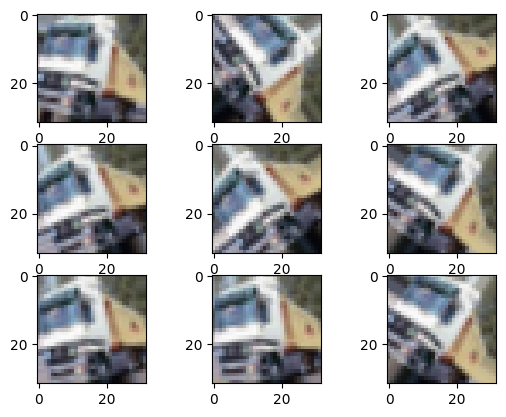

In [ ]:
sample_images = expand_dims(sample_image, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(sample_images, batch_size=1)
# generate sample images and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    image = batch[0];
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

## 1.1 Model with dense layer

In [ ]:
def model_summarize(history):
    '''
    Summarize model i.e. print train and test loss
    '''
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.show()

In [ ]:
def model_harness(X_train, y_train, X_test, y_test, given_batch_size, given_step_size, given_epochs):
    '''
    define model using data augmentation technique and extend it to it's vertical limit
    '''
    # model = pickle.load('densenet.pkl')
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    iterator_train = datagen.flow(X_train, y_train, batch_size=given_batch_size)
    # fit model
    steps = int(X_train.shape[0] / given_step_size)
    history = model.fit_generator(iterator_train, steps_per_epoch=steps, epochs=given_epochs, validation_data=(X_test, y_test), verbose=1)
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
   
    model_summarize(history)

In [ ]:
def denseblock(input, num_filter = 64, dropout_rate = 0):
    '''
    Create dense block
    '''
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer="he_uniform" ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

def transition(input, num_filter = 32, dropout_rate = 0):
    '''
    Create transition block
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), kernel_initializer="he_uniform" ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    define output layer
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    
    return output

In [ ]:
num_filter = 10
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel))
First_Conv2D = layers.Conv2D(num_filter, (5,5), use_bias=False ,padding='same')(input)
BatchNorm = layers.BatchNormalization()(First_Conv2D)

First_Block = denseblock(BatchNorm,32, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, 16, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 10)   750         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 32, 32, 10)   40          conv2d_52[0][0]                  
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 10)   40          batch_normalization_52[0][0]     
____________________________________________________________________________________________

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
781/781 [==============================] - 83s 107ms/step - loss: 1.6684 - accuracy: 0.3792 - val_loss: 1.4304 - val_accuracy: 0.4914
Epoch 2/75
781/781 [==============================] - 82s 105ms/step - loss: 1.3260 - accuracy: 0.5175 - val_loss: 1.3210 - val_accuracy: 0.5277
Epoch 3/75
781/781 [==============================] - 82s 105ms/step - loss: 1.1522 - accuracy: 0.5854 - val_loss: 1.3607 - val_accuracy: 0.5235
Epoch 4/75
781/781 [==============================] - 84s 107ms/step - loss: 1.0313 - accuracy: 0.6312 - val_loss: 1.0919 - val_accuracy: 0.6118
Epoch 5/75
781/781 [==============================] - 84s 107ms/step - loss: 0.9370 - accuracy: 0.6667 - val_loss: 0.9598 - val_accuracy: 0.6625
Epoch 6/75
781/781 [==============================] - 84s 107ms/step - loss: 0.8641 - accuracy: 0.6973 - val_loss: 1.3034 - val_accuracy: 0.5862
Epoch 7/75
781/781 [==============================] - 

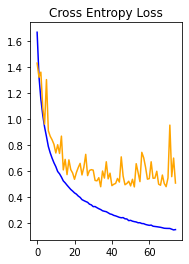

In [ ]:
# entry point, run the test harness
model_harness(X_train, y_train, X_test, y_test, 64, 64, 75)

In [ ]:
model.save_weights("DNST_model_with_dense_layer.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
del model

## 1.2 Model without Dense layer and implemented all tweaks mentioned in the assignment task ##

In [ ]:
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    '''
    Create Dense Block
    '''
    global compression
    temp = input
    for _ in range(l): 
        
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
            
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

def transition(input, num_filter = 12, dropout_rate = 0.2):
    '''
    Create transition block
    '''
    global compression
    
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
            
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    Define output layer
    '''
    global compression
    
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers. MaxPooling2D(pool_size=(2,2))(relu)
    
    output = layers.Conv2D(filters=10,kernel_size=(2,2),activation='softmax')(AvgPooling)
   
    flat = layers.Flatten()(output)
    
    return flat

In [ ]:
num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 32)   128         conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 32, 32, 32)   0           batch_normalization_53[0][0]     
______________________________________________________________________________________________

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
# entry point, run the test harness for 50 * 5 iterations, 1st slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 50)

Epoch 1/50
1282/1282 [==============================] - 122s 95ms/step - loss: 0.8660 - accuracy: 0.6932 - val_loss: 1.0409 - val_accuracy: 0.6576
Epoch 2/50
1282/1282 [==============================] - 123s 96ms/step - loss: 0.6867 - accuracy: 0.7593 - val_loss: 1.0192 - val_accuracy: 0.6963
Epoch 3/50
1282/1282 [==============================] - 122s 95ms/step - loss: 0.5855 - accuracy: 0.7983 - val_loss: 0.7289 - val_accuracy: 0.7644
Epoch 4/50
1282/1282 [==============================] - 122s 95ms/step - loss: 0.5207 - accuracy: 0.8198 - val_loss: 0.7642 - val_accuracy: 0.7520
Epoch 5/50
1282/1282 [==============================] - 122s 95ms/step - loss: 0.4703 - accuracy: 0.8362 - val_loss: 0.8759 - val_accuracy: 0.7475
Epoch 6/50
1282/1282 [==============================] - 122s 95ms/step - loss: 0.4331 - accuracy: 0.8500 - val_loss: 0.5181 - val_accuracy: 0.8315
Epoch 7/50
1282/1282 [==============================] - 122s 95ms/step - loss: 0.3976 - accuracy: 0.8632 - val_loss: 0

Epoch 1/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0862 - accuracy: 0.9690 - val_loss: 0.5547 - val_accuracy: 0.8716
Epoch 2/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0872 - accuracy: 0.9692 - val_loss: 0.5588 - val_accuracy: 0.8696
Epoch 3/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0818 - accuracy: 0.9715 - val_loss: 0.5206 - val_accuracy: 0.8823
Epoch 4/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0854 - accuracy: 0.9698 - val_loss: 0.5070 - val_accuracy: 0.8804
Epoch 5/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0776 - accuracy: 0.9723 - val_loss: 0.5580 - val_accuracy: 0.8731
Epoch 6/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0812 - accuracy: 0.9714 - val_loss: 0.6004 - val_accuracy: 0.8623
Epoch 7/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0774 - accuracy: 0.9727 - val_loss: 0

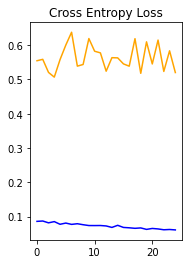

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 2nd slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 120s 94ms/step - loss: 0.0615 - accuracy: 0.9785 - val_loss: 0.5160 - val_accuracy: 0.8866
Epoch 2/25
1282/1282 [==============================] - 120s 94ms/step - loss: 0.0589 - accuracy: 0.9795 - val_loss: 0.5773 - val_accuracy: 0.8808
Epoch 3/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0590 - accuracy: 0.9792 - val_loss: 0.5458 - val_accuracy: 0.8872
Epoch 4/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0590 - accuracy: 0.9787 - val_loss: 0.6247 - val_accuracy: 0.8708
Epoch 5/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0579 - accuracy: 0.9794 - val_loss: 0.6266 - val_accuracy: 0.8707
Epoch 6/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0569 - accuracy: 0.9798 - val_loss: 0.5833 - val_accuracy: 0.8807
Epoch 7/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0593 - accuracy: 0.9789 - val_loss: 0

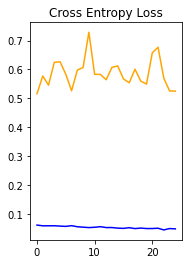

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 3rd slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0470 - accuracy: 0.9830 - val_loss: 0.6054 - val_accuracy: 0.8792
Epoch 2/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0469 - accuracy: 0.9839 - val_loss: 0.5582 - val_accuracy: 0.8873
Epoch 3/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0456 - accuracy: 0.9838 - val_loss: 0.5284 - val_accuracy: 0.8914
Epoch 4/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0457 - accuracy: 0.9837 - val_loss: 0.6097 - val_accuracy: 0.8796
Epoch 5/25
1282/1282 [==============================] - 120s 94ms/step - loss: 0.0422 - accuracy: 0.9850 - val_loss: 0.5924 - val_accuracy: 0.8871
Epoch 6/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0474 - accuracy: 0.9836 - val_loss: 0.5490 - val_accuracy: 0.8897
Epoch 7/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0

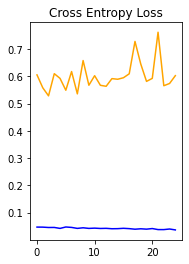

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 4th slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0383 - accuracy: 0.9865 - val_loss: 0.6244 - val_accuracy: 0.8817
Epoch 2/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.5762 - val_accuracy: 0.8912
Epoch 3/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0382 - accuracy: 0.9864 - val_loss: 0.6020 - val_accuracy: 0.8875
Epoch 4/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0387 - accuracy: 0.9866 - val_loss: 0.6606 - val_accuracy: 0.8794
Epoch 5/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0374 - accuracy: 0.9870 - val_loss: 0.6488 - val_accuracy: 0.8820
Epoch 6/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0356 - accuracy: 0.9875 - val_loss: 0.5999 - val_accuracy: 0.8901
Epoch 7/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0368 - accuracy: 0.9870 - val_loss: 0

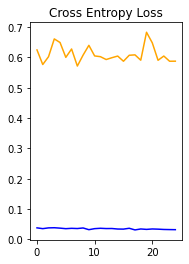

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 5th slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0309 - accuracy: 0.9892 - val_loss: 0.6036 - val_accuracy: 0.8879
Epoch 2/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0327 - accuracy: 0.9885 - val_loss: 0.5816 - val_accuracy: 0.8914
Epoch 3/25
1282/1282 [==============================] - 122s 96ms/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.5437 - val_accuracy: 0.9013
Epoch 4/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0320 - accuracy: 0.9887 - val_loss: 0.5891 - val_accuracy: 0.8911
Epoch 5/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0322 - accuracy: 0.9888 - val_loss: 0.6661 - val_accuracy: 0.8830
Epoch 6/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.6304 - val_accuracy: 0.8880
Epoch 7/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0351 - accuracy: 0.9879 - val_loss: 0

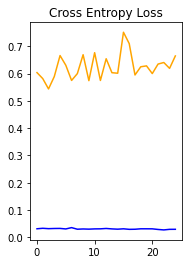

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 6th slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0280 - accuracy: 0.9900 - val_loss: 0.6893 - val_accuracy: 0.8854
Epoch 2/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0294 - accuracy: 0.9895 - val_loss: 0.6329 - val_accuracy: 0.8846
Epoch 3/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0279 - accuracy: 0.9903 - val_loss: 0.6261 - val_accuracy: 0.8937
Epoch 4/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0274 - accuracy: 0.9909 - val_loss: 0.5996 - val_accuracy: 0.8953
Epoch 5/25
1282/1282 [==============================] - 123s 96ms/step - loss: 0.0289 - accuracy: 0.9901 - val_loss: 0.6283 - val_accuracy: 0.8869
Epoch 6/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0293 - accuracy: 0.9900 - val_loss: 0.5977 - val_accuracy: 0.8935
Epoch 7/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0287 - accuracy: 0.9904 - val_loss: 0

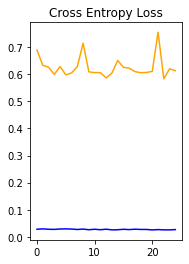

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 7th slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0243 - accuracy: 0.9915 - val_loss: 0.6682 - val_accuracy: 0.8857
Epoch 2/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0.6053 - val_accuracy: 0.8943
Epoch 3/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0242 - accuracy: 0.9914 - val_loss: 0.6644 - val_accuracy: 0.8916
Epoch 4/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0243 - accuracy: 0.9915 - val_loss: 0.6988 - val_accuracy: 0.8882
Epoch 5/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.6393 - val_accuracy: 0.8927
Epoch 6/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0245 - accuracy: 0.9914 - val_loss: 0.6389 - val_accuracy: 0.8947
Epoch 7/25
1282/1282 [==============================] - 122s 95ms/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0

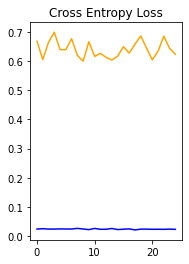

In [ ]:
# entry point, run the test harness for 25 * 8 iterations, 8th slot will be:
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_without_dense_layer.h5")
print("Saved model to disk")

Saved model to disk


Epoch 1/25
1282/1282 [==============================] - 117s 92ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.6264 - val_accuracy: 0.8953
Epoch 2/25
1282/1282 [==============================] - 120s 93ms/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.6088 - val_accuracy: 0.8963
Epoch 3/25
1282/1282 [==============================] - 120s 94ms/step - loss: 0.0233 - accuracy: 0.9921 - val_loss: 0.6136 - val_accuracy: 0.8960
Epoch 4/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 0.6241 - val_accuracy: 0.8925
Epoch 5/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0206 - accuracy: 0.9925 - val_loss: 0.7215 - val_accuracy: 0.8810
Epoch 6/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0222 - accuracy: 0.9919 - val_loss: 0.6209 - val_accuracy: 0.8916
Epoch 7/25
1282/1282 [==============================] - 121s 95ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0

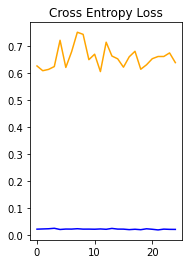

In [ ]:
# entry point, run the test harness
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

Epoch 1/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0218 - accuracy: 0.9925 - val_loss: 0.6757 - val_accuracy: 0.8907
Epoch 2/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.6745 - val_accuracy: 0.8895
Epoch 3/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0197 - accuracy: 0.9929 - val_loss: 0.6257 - val_accuracy: 0.8967
Epoch 4/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0213 - accuracy: 0.9925 - val_loss: 0.6570 - val_accuracy: 0.8946
Epoch 5/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.6668 - val_accuracy: 0.8933
Epoch 6/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0214 - accuracy: 0.9928 - val_loss: 0.6113 - val_accuracy: 0.8952
Epoch 7/25
1282/1282 [==============================] - 121s 94ms/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0

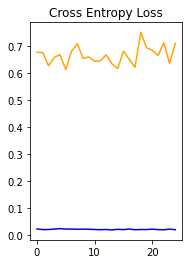

In [ ]:
# entry point, run the test harness
model_harness(X_train, y_train, X_test, y_test, 60, 39, 25)

## **Result:**  ##

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Model', 'Epochs', 'Train Accuracy', 'Test Accuracy']
table.add_row(['Without dense layer', '300', 0.99366578,  0.8873457])
table.add_row(['With dense layer ', 75, 0.94785467, 0.8603194])

print(table)

+---------------------+--------+----------------+---------------+
|        Model        | Epochs | Train Accuracy | Test Accuracy |
+---------------------+--------+----------------+---------------+
| Without dense layer |  300   |   0.99366578   |   0.8873457   |
|  With dense layer   |   75   |   0.94785467   |   0.8603194   |
+---------------------+--------+----------------+---------------+
